In [1]:
# install catboost
!pip install catboost
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [31]:
!pip install ipywidgets

In [2]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [3]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from datetime import datetime, date, timedelta

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.preprocessing import StandardScaler

from inspect import signature


from catboost import *


In [4]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


# Exploring the dataset. Descriptive statistic

In [4]:
transactions = pd.read_csv('data/transactions.csv', sep=';')
types = pd.read_csv('data/types.csv', sep=';')
codes = pd.read_csv('data/codes.csv', sep=';')
train_set = pd.read_csv('data/train_set.csv', sep=';')


In [101]:
# transactions = pd.read_csv('/gdrive/MyDrive/Colab Notebooks/data-mining assignments/data/transactions.csv', sep=';')
# types = pd.read_csv('/gdrive/MyDrive/Colab Notebooks/data-mining assignments/data/types.csv', sep=';')
# codes = pd.read_csv('/gdrive/MyDrive/Colab Notebooks/data-mining assignments/data/codes.csv', sep=';')
# train_set = pd.read_csv('/gdrive/MyDrive/Colab Notebooks/data-mining assignments/data/train_set.csv', sep=';')

# /gdrive/MyDrive/Colab Notebooks/data-mining assignments/data/codes.csv


#### Description 
**transactions.csv** columns description: 
- client_id - client is id 
- datetime -transaction date (format - ordered day number hh:mm:ss - 421 06:33:15) 
- code - transaction code 
- type - transaction type
- sum - sum of transaction

In [5]:
transactions = transactions.merge(types, how='left', on='type').copy()
df = transactions.merge(codes, how='left', on='code').copy() 
df = df.merge(train_set, how='left', on='client_id')
# merging all dataframes into one

In [6]:
df.dropna(subset=['target'],inplace=True)
df.head()
# dropping rows where target value is NaN

,client_id,datetime,code,type,sum,type_description,code_description,target
0,96372458,421 06:33:15,6011,2010,-561478.94,Выдача наличных в АТМ,Финансовые институты — снятие наличности автом...,0.0
2,21717441,55 13:38:47,6011,2010,-44918.32,Выдача наличных в АТМ,Финансовые институты — снятие наличности автом...,0.0
4,85302434,151 10:34:12,4814,1030,-3368.87,Оплата услуги. Банкоматы,"Звонки с использованием телефонов, считывающих...",0.0
5,31421357,398 00:00:00,5411,1110,-1572.14,Покупка. POS,"Бакалейные магазины, супермаркеты",0.0
6,84826852,423 15:27:55,6010,7070,5654.99,Перевод на карту (с карты) через Мобильный бан...,Финансовые институты — снятие наличности вручную,1.0


In [7]:
print("Shape of df:", df.shape)
print("Unique clients number:", df.client_id.nunique())

Shape of df: (91826, 8)
Unique clients number: 6000


In [8]:
df.groupby('target')['client_id'].count()

# checking if the data is imbalanced or not

target
0.0    46715
1.0    45111
Name: client_id, dtype: int64

In [9]:
df.head()

,client_id,datetime,code,type,sum,type_description,code_description,target
0,96372458,421 06:33:15,6011,2010,-561478.94,Выдача наличных в АТМ,Финансовые институты — снятие наличности автом...,0.0
2,21717441,55 13:38:47,6011,2010,-44918.32,Выдача наличных в АТМ,Финансовые институты — снятие наличности автом...,0.0
4,85302434,151 10:34:12,4814,1030,-3368.87,Оплата услуги. Банкоматы,"Звонки с использованием телефонов, считывающих...",0.0
5,31421357,398 00:00:00,5411,1110,-1572.14,Покупка. POS,"Бакалейные магазины, супермаркеты",0.0
6,84826852,423 15:27:55,6010,7070,5654.99,Перевод на карту (с карты) через Мобильный бан...,Финансовые институты — снятие наличности вручную,1.0


# Visualizations

,type,sum,type_description
0,1010,21427,Покупка. POS
1,2010,14135,Выдача наличных в АТМ
2,1030,12848,Оплата услуги. Банкоматы
3,1110,12276,Покупка. POS
4,7070,9808,Перевод на карту (с карты) через Мобильный бан...
5,2370,4788,Списание с карты на карту по операции <перевод...
6,7010,3529,Взнос наличных через АТМ (в своем тер.банке)
7,7030,2092,Перевод на карту (с карты) через АТМ (в предел...
8,1100,1492,Покупка.
9,1200,1251,Покупка. Зарубеж.


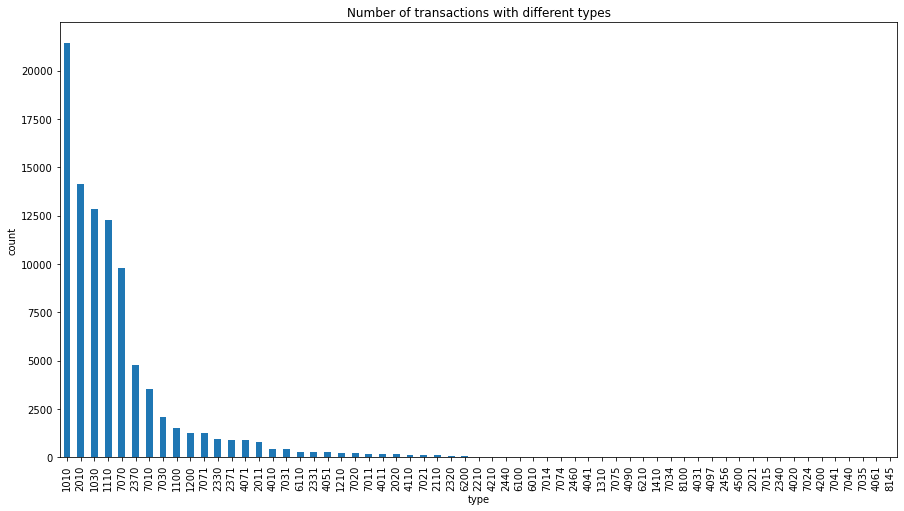

In [10]:
fig = plt.figure(figsize=(15, 8))

tmp = df.groupby('type')['sum'].count().sort_values(ascending=False)

tmp.plot(kind='bar')
plt.xlabel('type')
plt.ylabel('count')
plt.title('Number of transactions with different types')

pd.merge(tmp[:15].reset_index(), types)
# top 15

In [11]:
#ratio by transaction type

tmp = pd.merge(pd.crosstab(df.type, df.target).reset_index(), types)

tmp['ratio'] = (abs(tmp[0.0] - tmp[1.0])/(tmp[0.0] + tmp[1.0]))
tmp = tmp[(tmp[0.0] + tmp[1.0]) > 50] # е. достаточно статистики
tmp.sort_values('ratio',  ascending=False, inplace=True)
tmp.columns = ['transaction_type', 'f', 'm', 'description', 'ratio']

tmp.head(10)

,transaction_type,f,m,description,ratio
37,6200,49,13,Возврат покупки. Зарубеж.,0.580645
53,7071,400,836,Перевод на карту (с карты) через Мобильный бан...,0.352751
40,7011,63,113,Взнос наличных через АТМ,0.284091
30,4110,46,77,Плата за получение наличных в АТМ.,0.252033
12,2110,39,64,Наличные. АТМ,0.242718
43,7020,135,88,Взнос наличных через POS,0.210762
14,2320,41,27,Безналичный перевод денежных средств через POS,0.205882
44,7021,42,63,Взнос наличных через POS,0.200000
36,6110,113,167,Возврат покупки. POS,0.192857
4,1200,517,734,Покупка. Зарубеж.,0.173461


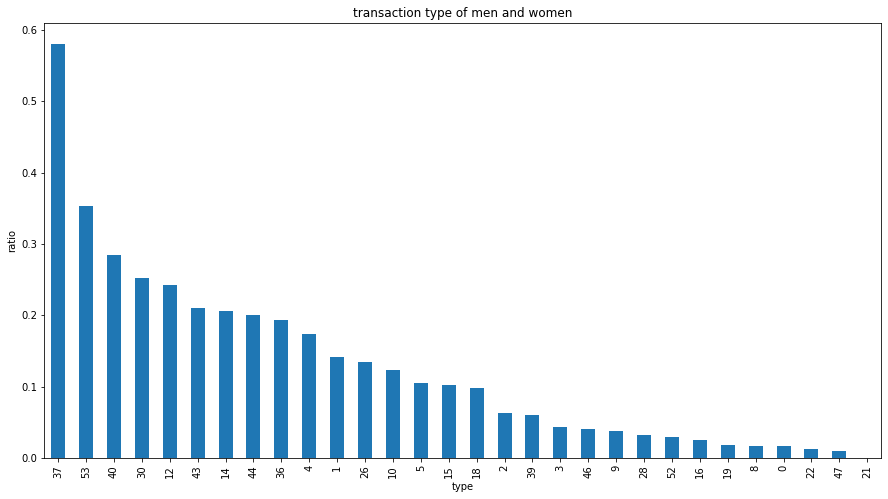

In [12]:
fig = plt.figure(figsize=(15, 8))

pt = tmp.head(50).ratio.plot(kind='bar')
pt.set_xlabel('type')
pt.set_ylabel('ratio')
pt.set_title('transaction type of men and women')

plt.show()

,code,sum,code_description
0,6011,19538,Финансовые институты — снятие наличности автом...
1,6010,14093,Финансовые институты — снятие наличности вручную
2,4814,13044,"Звонки с использованием телефонов, считывающих..."
3,5411,13003,"Бакалейные магазины, супермаркеты"
4,4829,8134,Денежные переводы
5,5499,4456,"Различные продовольственные магазины — рынки, ..."
6,5912,1862,Аптеки
7,5541,1831,Станции техобслуживания
8,5331,1687,Универсальные магазины
9,5812,1448,"Места общественного питания, рестораны"


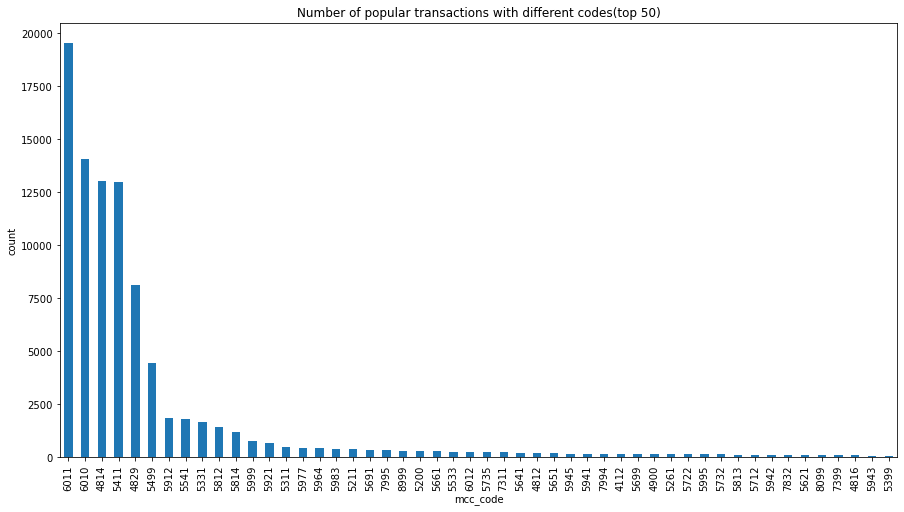

In [13]:
# Popular codes

fig = plt.figure(figsize=(15, 8))

tmp = df.groupby('code')['sum'].count().sort_values(ascending=False)
tmp.head(50).plot(kind='bar')
plt.xlabel('mcc_code')
plt.ylabel('count')
plt.title('Number of popular transactions with different codes(top 50)')
pd.merge(tmp.head(15).reset_index(), codes)


In [14]:
# ratio by description

tmp = pd.merge(pd.crosstab(df.code, df.target).reset_index(), codes)

tmp['ratio'] = abs(tmp[0.0] - tmp[1.0])/(tmp[0.0] + tmp[1.0])
tmp = tmp[(tmp[0.0] + tmp[1.0]) > 50]

tmp.sort_values('ratio',  ascending=False, inplace=True)
tmp.columns = ['mcc_code', 'w', 'm', 'mcc_description', 'ratio']

tmp.head(10)

,mcc_code,w,m,mcc_description,ratio
152,7994,24,152,Галереи/учреждения видеоигр,0.727273
64,5621,92,15,Готовые сумочные изделия,0.719626
153,7995,54,292,Транзакции по азартным играм,0.687861
110,5977,385,74,Магазины косметики,0.677560
59,5533,46,226,Автозапчасти и аксессуары,0.661765
120,6051,15,62,"Не-финансовые институты — иностранная валюта, ...",0.610390
111,5983,100,308,"Горючее топливо — уголь, нефть, разжиженный бе...",0.509804
67,5651,144,49,Одежда для всей семьи,0.492228
60,5541,474,1357,Станции техобслуживания,0.482250
102,5964,311,112,Прямой маркетинг — торговля через каталог,0.470449


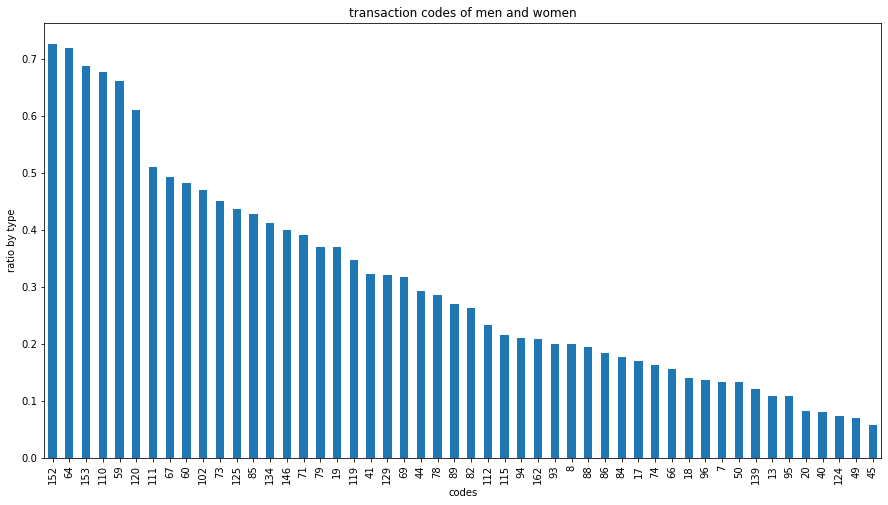

In [15]:
fig = plt.figure(figsize=(15, 8))

pt = tmp.head(50).ratio.plot(kind='bar')
pt.set_xlabel('codes')
pt.set_ylabel('ratio by type')
pt.set_title('transaction codes of men and women')

plt.show()

# Feature engineering

In [16]:
def find_date(day_num):
    '''
    Returns the date according to day number
    Start date: 1 January, 2020 (153 day). 
    We depicted the graph of day distribution by the number of orders,
    and we saw that the 153th was with the least number of orders, 
    that is why we assumed it to be the 1st January
    '''
    strt_date = date(2020, 1, 1)
    day_num = day_num - 153
    res_date = strt_date + timedelta(days=day_num)
    
    res = res_date.strftime("%d-%m-%Y")
    
    return res

In [17]:
df['datetime'] = df['datetime'].apply(lambda x: find_date(int(x.split(' ')[0]))) + ' ' + df['datetime'].apply(lambda s : s.split(' ')[1])
df['datetime'] = pd.to_datetime(df['datetime'], format='%d-%m-%Y %H:%M:%S')

# recreating datetime column

In [18]:
df['weekday'] = df.datetime.apply(lambda x: x.weekday())
df['hour'] = df.datetime.apply(lambda x: x.hour)

In [19]:
def time_type(h):
    if h>=6 and h<12:
        return 'morning'
    elif h>=12 and  h<18:
        return 'day'
    elif h>=18 and h<23:
        return 'evening'
    else:
        return 'night'
    
df['time_type'] = df.hour.apply(lambda x: time_type(x))

df['time_type'] = df['time_type'].factorize()[0]
# Morning -> 0
# Day -> 1
# Night -> 2
# Evening ->3

In [20]:
# Number of purchases in each category

F1 = df.groupby('client_id') \
                    .apply(lambda x: x[['code']].unstack().value_counts()) \
                    .unstack() \
                    .fillna(0)
F1.rename(columns=lambda x: 'mcc_code_value_counts_'+str(x), inplace=True)

# Sum of purchases in each category
F2 = df.groupby('client_id').apply(lambda x : x.groupby('code')['sum'].sum()).unstack().fillna(0)
F2.rename(columns=lambda x: 'sum_'+str(x), inplace=True)

# Maximum purchase in each category

F3 = df.groupby('client_id').apply(lambda x : x.groupby('code')['sum'].max()).unstack().fillna(0)
F3.rename(columns=lambda x: 'max_'+str(x), inplace=True)

# St.deviation of purchases in each category

F4 = df.groupby('client_id').apply(lambda x : x.groupby('code')['sum'].std()).unstack().fillna(0)
F4.rename(columns=lambda x: 'std_'+str(x), inplace=True)

# Mean of purchases in each category

F5 = df.groupby('client_id').apply(lambda x : x.groupby('code')['sum'].mean()).unstack().fillna(0)
F5.rename(columns=lambda x: 'mean_'+str(x), inplace=True)

# Number of transaction type
F6 = df.groupby('client_id') \
                    .apply(lambda x: x[['type']].unstack().value_counts()) \
                    .unstack() \
                    .fillna(0)
F6.rename(columns=lambda x: 'tr_type_value_counts_'+str(x), inplace=True)

# Sum of purchases in each transaction type
F7 = df.groupby('client_id').apply(lambda x : x.groupby('type')['sum'].sum()).unstack().fillna(0)
F7.rename(columns=lambda x: 'tr_type_sum_'+str(x), inplace=True)


# Maximum purchases in each transaction type
F8 = df.groupby('client_id').apply(lambda x : x.groupby('type')['sum'].max()).unstack().fillna(0)
F8.rename(columns=lambda x: 'tr_type_max_'+str(x), inplace=True)

# St.deviation of purchases in each transaction type
F9 = df.groupby('client_id').apply(lambda x : x.groupby('type')['sum'].std()).unstack().fillna(0)
F9.rename(columns=lambda x: 'tr_type_std_'+str(x), inplace=True)

# Mean of purchases in transaction type
F10 = df.groupby('client_id').apply(lambda x : x.groupby('type')['sum'].mean()).unstack().fillna(0)
F10.rename(columns=lambda x: 'tr_type_mean_'+str(x), inplace=True)

# Mean of purchases over weekdays
F11 = df.groupby('client_id').apply(lambda x : x.groupby('weekday')['sum'].mean()).unstack().fillna(0)
F11.rename(columns=lambda x: 'mean_transactions_count_by_week_day_'+str(x), inplace=True)

# Mean of purchases in each hour
F12 = df.groupby('client_id').apply(lambda x : x.groupby('hour')['sum'].mean()).unstack().fillna(0)
F12.rename(columns=lambda x: 'mean_transactions_count_by_h_'+str(x), inplace=True)

# Mean of purchases in each time types
F13 = df.groupby('client_id').apply(lambda x : x.groupby('time_type')['sum'].mean()).unstack().fillna(0)
F13.rename(columns=lambda x: 'mean_transactions_count_by_time_type_'+str(x), inplace=True)

In [21]:
df_new = pd.concat([F1, F2, F3, F4, F5, F6, F7, F8, F9, F10, F11, F12, F13], axis=1, join='inner')


In [22]:
# Final dataframe with all features

df_new = df_new.merge(train_set, how='left', on='client_id')
df_new.head()

,client_id,mcc_code_value_counts_742,mcc_code_value_counts_1711,mcc_code_value_counts_1799,mcc_code_value_counts_3000,mcc_code_value_counts_3351,mcc_code_value_counts_3501,mcc_code_value_counts_4111,mcc_code_value_counts_4112,mcc_code_value_counts_4121,...,mean_transactions_count_by_h_19,mean_transactions_count_by_h_20,mean_transactions_count_by_h_21,mean_transactions_count_by_h_22,mean_transactions_count_by_h_23,mean_transactions_count_by_time_type_0,mean_transactions_count_by_time_type_1,mean_transactions_count_by_time_type_2,mean_transactions_count_by_time_type_3,target
0,22899,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,22459.160,0.00,0.0,0.0,13756.235000,-7336.656667,0.0000,8916.285000,1
1,27914,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.000,0.00,0.0,0.0,4491.830000,32565.775000,0.0000,0.000000,1
2,28753,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.000,0.00,0.0,0.0,102678.554000,-15275.970000,-611473.0300,0.000000,0
3,38084,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1145.42,0.000,-13032.49,0.0,0.0,198670.566000,13392.957000,-67107.5125,-23622.384286,0
4,49793,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1933.73,-4336.305,0.00,0.0,0.0,-3743.196667,-122419.786364,-3957.3050,-3330.424000,1


In [23]:
print("Total number of features:", df_new.shape[1])

Total number of features: 1207


# Supervised learning

In [24]:
X = df_new.drop(['target'], axis=1)
y = df_new['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=888)


## Decision tree

In [26]:
tree = DecisionTreeClassifier(random_state=17)
tree.fit(X_train, y_train)


DecisionTreeClassifier(random_state=17)

In [27]:
tree_pred = tree.predict(X_test)
accuracy_score(y_test, tree_pred) 

0.6113333333333333

### Gridsearch, cross-validation

In [28]:
tree_params = {"max_depth": range(1, 30), "max_features": range(1, 1207, 50)}
tree_grid = GridSearchCV(tree, tree_params, cv=5, n_jobs=-1, verbose=True)

tree_grid.fit(X_train, y_train)

Fitting 5 folds for each of 725 candidates, totalling 3625 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=17), n_jobs=-1,
             param_grid={'max_depth': range(1, 30),
                         'max_features': range(1, 1207, 50)},
             verbose=True)

In [29]:
tree_grid.best_params_

{'max_depth': 5, 'max_features': 1001}

## kNN

In [84]:
# for kNN, we need to scale features

knn = KNeighborsClassifier(n_neighbors=10)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
knn.fit(X_train_scaled, y_train);

In [85]:
knn_pred = knn.predict(X_test_scaled)
accuracy_score(y_test, knn_pred)

0.616

### Gridsearch, cross-validation

In [80]:
knn = KNeighborsClassifier()
k_range = list(range(1, 51))
param_grid = dict(n_neighbors=k_range)
  
# defining parameter range
grid = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy', return_train_score=False, verbose=1)
  
# fitting the model for grid search
grid_search = grid.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


In [83]:
print(grid_search.best_params_)

{'n_neighbors': 27}


## Random Forest

In [41]:
rfc = RandomForestClassifier(random_state=42)

# fit the model
rfc.fit(X_train, y_train)

# Predict the Test set results
y_pred = rfc.predict(X_test)

In [42]:
print('Model accuracy score with 10 decision-trees : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy score with 10 decision-trees : 0.6720


### Gridsearch, cross-validation

In [43]:
rfc=RandomForestClassifier(random_state=42)

param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7, 8],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [200, 500]})

In [44]:
CV_rfc.best_params_

{'criterion': 'gini',
 'max_depth': 8,
 'max_features': 'auto',
 'n_estimators': 500}

In [45]:
rfc1=RandomForestClassifier(random_state=42, max_features='auto', n_estimators= 500, max_depth=8, criterion='gini')
rfc1.fit(X_train, y_train)

RandomForestClassifier(max_depth=8, n_estimators=500, random_state=42)

## Gradient Boosting (CatBoost)


In [25]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [ ]:
from catboost import CatBoostClassifier

model = CatBoostClassifier(
    iterations=1000,
    random_seed=2022,
    learning_rate=0.02,
    custom_loss=['AUC', 'Accuracy']
)
model.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [120]:
model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,mcc_code_value_counts_5541,1.816762
1,std_6011,1.569602
2,mean_transactions_count_by_h_9,1.506401
3,mean_transactions_count_by_time_type_1,1.499340
4,sum_5541,1.495746
...,...,...
1201,tr_type_mean_7040,0.000000
1202,tr_type_mean_7041,0.000000
1203,tr_type_mean_7075,0.000000
1204,tr_type_mean_8100,0.000000


In [121]:
from catboost import cv

params = {}
params['loss_function'] = 'Logloss'
params['iterations'] = 1000
params['custom_loss'] = 'AUC'
params['random_seed'] = 63
params['learning_rate'] = 0.02

cv_data = cv(
    params = params,
    pool = Pool(X_train, label=y_train),
    fold_count=5,
    shuffle=True,
    partition_random_seed=0,
    plot=True,
    stratified=False,
    verbose=False
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.6008214244
bestIteration = 675

Training on fold [1/5]

bestTest = 0.5846491501
bestIteration = 976

Training on fold [2/5]

bestTest = 0.5939551525
bestIteration = 875

Training on fold [3/5]

bestTest = 0.6001234825
bestIteration = 655

Training on fold [4/5]

bestTest = 0.5961847707
bestIteration = 945



In [122]:
cv_data.head()

,iterations,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std,test-AUC-mean,test-AUC-std
0,0,0.691302,0.000421,0.691197,0.000402,0.611430,0.028537
1,1,0.689325,0.000512,0.688938,0.000398,0.630857,0.020444
2,2,0.687560,0.000322,0.687011,0.000487,0.643153,0.020954
3,3,0.685803,0.000330,0.685068,0.000481,0.650805,0.016559
4,4,0.684121,0.000511,0.683132,0.000435,0.660093,0.015596


In [123]:
best_value = np.min(cv_data['test-Logloss-mean'])
best_iter = np.argmin(cv_data['test-Logloss-mean'])

print('Best validation Logloss score, not stratified: {:.4f}±{:.4f} on step {}'.format(
    best_value,
    cv_data['test-Logloss-std'][best_iter],
    best_iter)
)

Best validation Logloss score, not stratified: 0.5959±0.0067 on step 887


In [69]:
from catboost.utils import get_roc_curve
import sklearn
from sklearn import metrics

eval_pool = Pool(X_test, y_test)
curve = get_roc_curve(model, eval_pool)
(fpr_boost, tpr_boost, thresholds) = curve
roc_auc_boost = sklearn.metrics.auc(fpr_boost, tpr_boost)

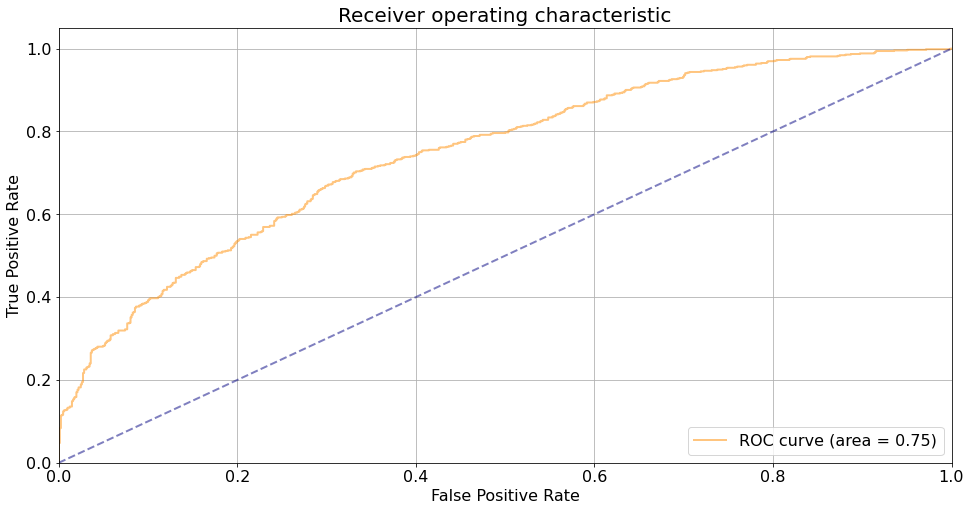

In [70]:
plt.figure(figsize=(16, 8))
lw = 2

plt.plot(fpr_boost, tpr_boost, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc_boost, alpha=0.5)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', alpha=0.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('Receiver operating characteristic', fontsize=20)
plt.legend(loc="lower right", fontsize=16)
plt.show()

# Analyzing results

## Results from Decision Tree model

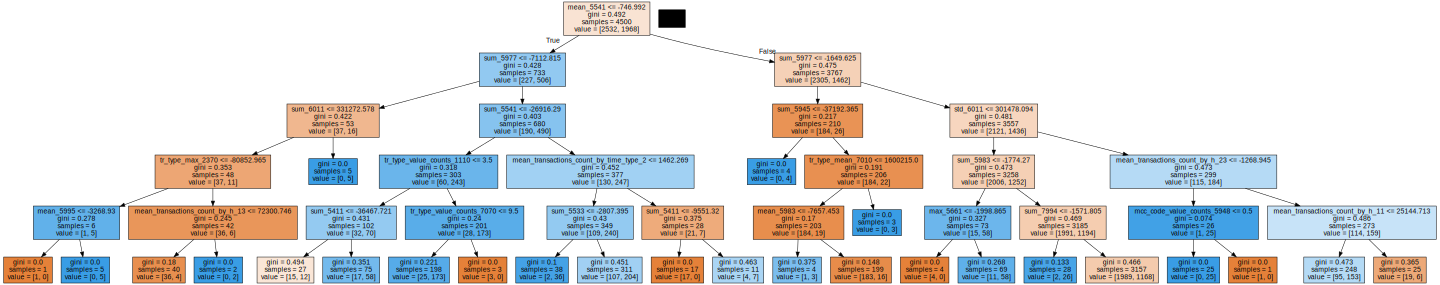

In [32]:
tree_best = tree_grid.best_estimator_

import pydotplus, graphviz
from sklearn.tree import export_graphviz

dot_data = export_graphviz(tree_best, 
                feature_names=X.columns,
                filled=True
                )

pydot_graph = pydotplus.graph_from_dot_data(dot_data)
pydot_graph.set_size('"20,5!"')

graphviz.Source(pydot_graph.to_string())

### ROC-AUC curve, precision, recall

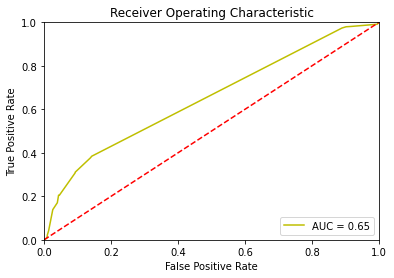

In [67]:
probs = tree_grid.predict_proba(X_test)
malignant_probs = probs[:,1]
fpr_tree, tpr_tree, thresholds = roc_curve(y_test, malignant_probs)
roc_auc_tree = auc(fpr_tree, tpr_tree)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr_tree, tpr_tree, 'y', label = 'AUC = %0.2f' % roc_auc_tree)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

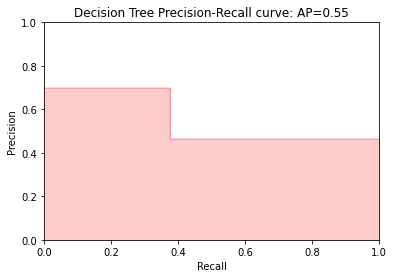

In [89]:
precision_tree, recall_tree, threshold_tree = precision_recall_curve(y_test, tree_grid.predict(X_test))
average_precision_tree = average_precision_score(y_test, tree_grid.predict(X_test))
step_kwargs = ({'step': 'post'} if 'step' in signature(plt.fill_between).parameters else {})
plt.step(recall_tree, precision_tree, color='r', alpha=0.2, where='post')
plt.fill_between(recall_tree, precision_tree, alpha=0.2, color='r', **step_kwargs)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.title('Decision Tree Precision-Recall curve: AP={0:0.2f}'.format(average_precision_tree))

plt.show()

## Results from kNN model

### ROC-AUC curve, precision, recall

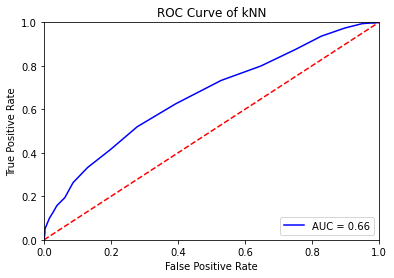

In [62]:
knn = KNeighborsClassifier(n_neighbors=27)
knn.fit(X_train_scaled, y_train)


y_scores = knn.predict_proba(X_test_scaled)
fpr_knn, tpr_knn, threshold = roc_curve(y_test, y_scores[:, 1])
roc_auc_knn = auc(fpr_knn, tpr_knn)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr_knn, tpr_knn, 'b', label = 'AUC = %0.2f' % roc_auc_knn)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of kNN')

plt.show()

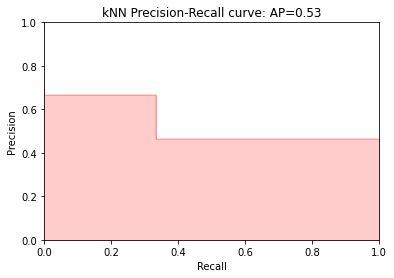

In [95]:
precision_knn, recall_knn, threshold_knn = precision_recall_curve(y_test, knn.predict(X_test_scaled))
average_precision_knn = average_precision_score(y_test, knn.predict(X_test_scaled))
step_kwargs = ({'step': 'post'} if 'step' in signature(plt.fill_between).parameters else {})
plt.step(recall_knn, precision_knn, color='r', alpha=0.2, where='post')
plt.fill_between(recall_knn, precision_knn, alpha=0.2, color='r', **step_kwargs)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.title('kNN Precision-Recall curve: AP={0:0.2f}'.format(average_precision_knn))

plt.show()

## Results from Random Forest model

### ROC-AUC curve, precision, recall

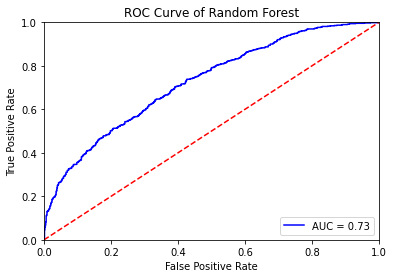

In [93]:
rfc = RandomForestClassifier(n_estimators=500, random_state=42, max_depth=8, max_features='auto')
rfc.fit(X_train, y_train)
y_scores = rfc.predict_proba(X_test)

fpr_rf, tpr_rf, threshold = roc_curve(y_test, y_scores[:, 1])
roc_auc_rf = auc(fpr_rf, tpr_rf)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr_rf, tpr_rf, 'b', label = 'AUC = %0.2f' % roc_auc_rf)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of Random Forest')

plt.show()

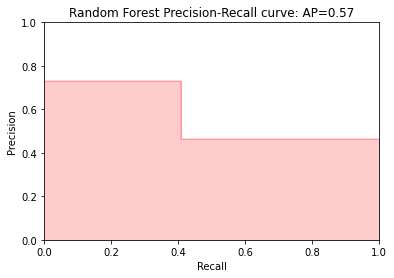

In [96]:
precision_rf, recall_rf, threshold_rf = precision_recall_curve(y_test, rfc.predict(X_test))
average_precision_rf = average_precision_score(y_test, rfc.predict(X_test))
step_kwargs = ({'step': 'post'} if 'step' in signature(plt.fill_between).parameters else {})
plt.step(recall_rf, precision_rf, color='r', alpha=0.2, where='post')
plt.fill_between(recall_rf, precision_rf, alpha=0.2, color='r', **step_kwargs)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.title('Random Forest Precision-Recall curve: AP={0:0.2f}'.format(average_precision_rf))

plt.show()

# Conclusion

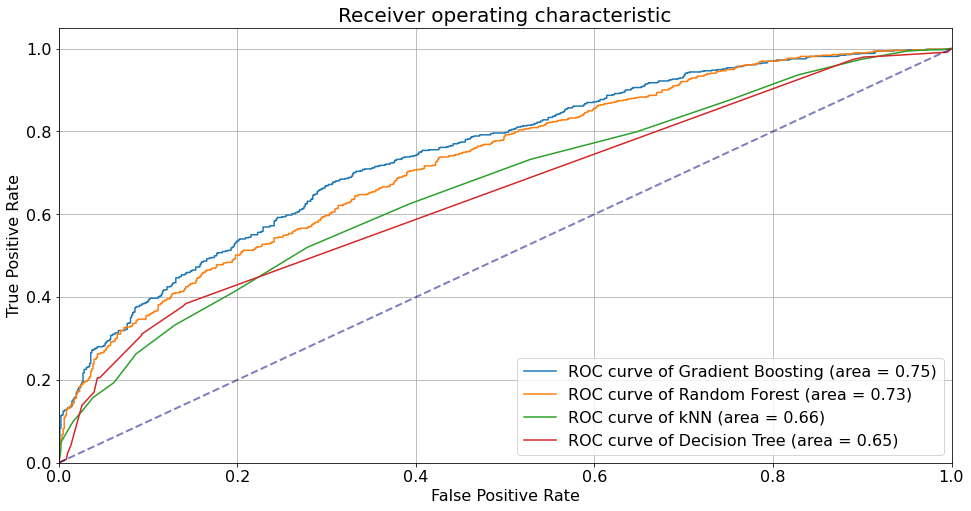

In [86]:
plt.figure(figsize=(16, 8))

plt.plot(fpr_boost, tpr_boost, label='ROC curve of Gradient Boosting (area = %0.2f)' % roc_auc_boost)
plt.plot(fpr_rf, tpr_rf, label='ROC curve of Random Forest (area = %0.2f)' % roc_auc_rf)
plt.plot(fpr_knn, tpr_knn, label='ROC curve of kNN (area = %0.2f)' % roc_auc_knn)
plt.plot(fpr_tree, tpr_tree, label='ROC curve of Decision Tree (area = %0.2f)' % roc_auc_tree)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', alpha=0.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('Receiver operating characteristic', fontsize=20)
plt.legend(loc="lower right", fontsize=16)
plt.show()

**As we see from above ROC-curves, Gradient boosting model without tuned parameters performs better than any other model with AUC score = 0.75. Surprisingly, kNN model works better than Decision Tree model, this might be because of scaled features used in kNN model.**

**Tuned hyperparameters for different models:**
* kNN - n_neighbors=27
* Decision Tree - max_depth: 5, max_features: 1001
* Random Forest - n_estimators=500, max_depth=8


